# Логистическая регрессия

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

## Загрузка, предварительный анализ данных
Сперва загрузим исследуемый набор данных

In [5]:
data = pd.read_csv('log-reg-data.csv')
display(data)

,feature_1,feature_2,target
0,5.657243,7.033854,0
1,2.204473,-5.082832,0
2,4.207860,12.717225,1
3,5.973029,17.616945,1
4,3.087534,9.967896,1
...,...,...,...
295,5.672426,16.996204,1
296,6.289975,11.011668,0
297,4.745107,14.030722,1
298,5.811345,7.401164,0


В наборе присутствует 300 объектов, каждый из которых имеет два признака и одно значение целевой переменной. Перед нами задача классификации, поскольку мы должны прогнозировать метку из $\{0,1\}$.

Переобозначим признаки за $X$, а таргет за $y$.

In [6]:
X = data.iloc[:, :-1].values
y = data['target'].values

Поскольку мы имеем дело с данными в $\mathbb R^2$, то их можно визуализировать.

> Почему в $\mathbb R^2$?

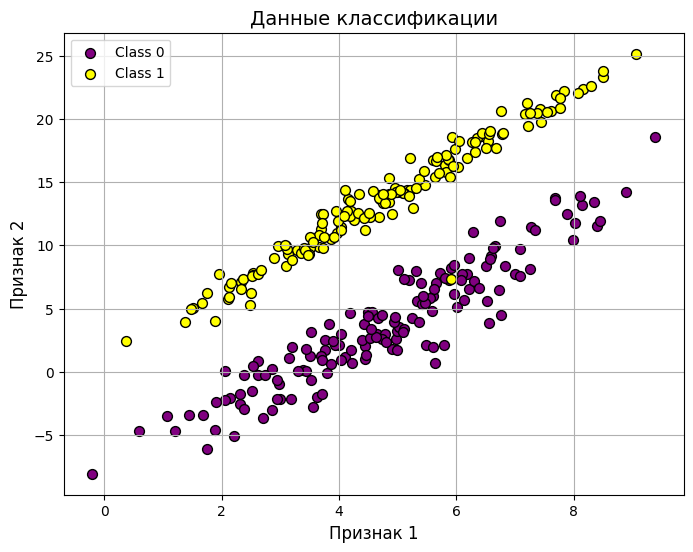

In [7]:
plt.figure(figsize=(8, 6))
scatter = plt.scatter(
    X[y == 0][:, 0], X[y == 0][:, 1], c='purple', edgecolor='k', s=50, label='Class 0', 
)

scatter = plt.scatter(
    X[y == 1][:, 0], X[y == 1][:, 1], c='yellow', edgecolor='k', s=50, label='Class 1',    
)

plt.title("Данные классификации", fontsize=14)
plt.xlabel("Признак 1", fontsize=12)
plt.ylabel("Признак 2", fontsize=12)
plt.legend()
plt.grid(True)
plt.show()

Заметим, что объекты линейно разделимы по классам. То есть это не вызовет проблем для модели логистической регрессии

## Построение модели логистической регрессии

Разделим выборку на обучающую и тестовую по методу отложенной выборки. На тест выделим $25\%$.

In [49]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

Функция $$\sigma (z) = \dfrac{1}{1+e^{-z}}$$ со значениями из отрезка $[0, 1]$ называется **сигмоидой**. Эту функцию мы будем применять для получения вероятностей принадлежности объекта классу. 

Реализуем эту функцию

In [50]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

Функция вида
$$H = \dfrac{1}{n} \sum_{k=1}^n y_k \ln \hat y_k + (1-y_k)\ln (1-\hat y_k),$$ называется **кросс-энтропией** и является целевой функцией в задаче двухклассовой классификации; здесь $y_k$ -- реальная метка класса, а $\hat y_k$ -- спрогнозированная метка класса.

In [51]:
def cross_entropy_loss(y_pred, y_true):
    return -np.mean(y_true * np.log(y_pred) + (1 - y_true) * np.log(1 - y_pred))

Какие мы ставили ключевые цели для модели логистической регрессии?

- модель возвращает вероятность $P(y=1 | x)$, то есть вероятность объекта принадлежать к классу 1.
- модель должна минимизировать значение кросс-энтропии.

Для решения задачи классификации мы должны решить задачу оптимизации 
$$\dfrac{1}{n} \sum_{i=1}^n y_k \ln \hat y_k + (1-y_k)\ln (1-\hat y_k) \to \min.$$

Итак, мы имеем на входе $n\times m$ матрицу объект-признак $X$ и вектор меток классов $y$. Для реализации модели логистической регрессии мы вводим вектор весов $$w = (w_0,\ldots, w_m),$$ который инициализируем некоторыми начальными значениями из равномерного распределения на отрезке $[0,1]$. Мы предполагаем, что истинную метку класса для объекта можно получить как
$$\hat y_k = \sigma(x^T_k w) = \dfrac{1}{1+e^{-x_k^Tw}},$$ где $$x_k \in \mathbb R^n$$ -- это вектор признаков $k$-ого объекта с меткой $y_k$.

Для обучения модели будем использовать градиентный спуск. Градиентный спуск определим следующим образом:
$$\dfrac{\partial H}{\partial w} = -\dfrac1n X^T(y - \sigma (Xw)),$$
$$w^{(k+1)} = w^{(k)} -\alpha \cdot \dfrac{\partial L}{\partial w^{(k)}},\ k=0,1,\ldots,$$
где $\alpha$ -- это шаг обучения. Мы будем считать $\alpha = 0.01$. 

Пусть $k=\overline{0,1000}$.

Нам также понадобится функция добавления фиктивного единичного признака

In [52]:
def add_const(X):
    return np.hstack([np.ones((X.shape[0], 1)), X])

Тогда в соответствии с описанными выше формулами можем построить алгоритм обучения модели

In [84]:
def fit(X, y, iterations=10000, lr=0.01):
    X = add_const(X) # добавляем фиктивный столбец
    n, m = X.shape
    weights = np.random.uniform(size=m) # инициализируем веса w из равномерного распределения [0,1]
    losses = [] # список для значений кросс-энтропии
    
    for i in range(iterations):
    
        z = X @ weights
        y_pred = sigmoid(z)
        
        grad = - (X.T @ (y - y_pred)) / n
        
        weights -= lr * grad
        
        loss = cross_entropy_loss(y_pred, y)
        losses.append(loss) # записываем кросс-энтропию в список
    
    return losses, weights

Теперь обучим логистическую регрессию на обучающем наборе

In [85]:
losses, weights = fit(X_train, y_train)

Для начала выведем график изменения кросс-энтропии, чтобы убедится в том, что обучение происходит корректно (то есть лосс должен минимизироваться)

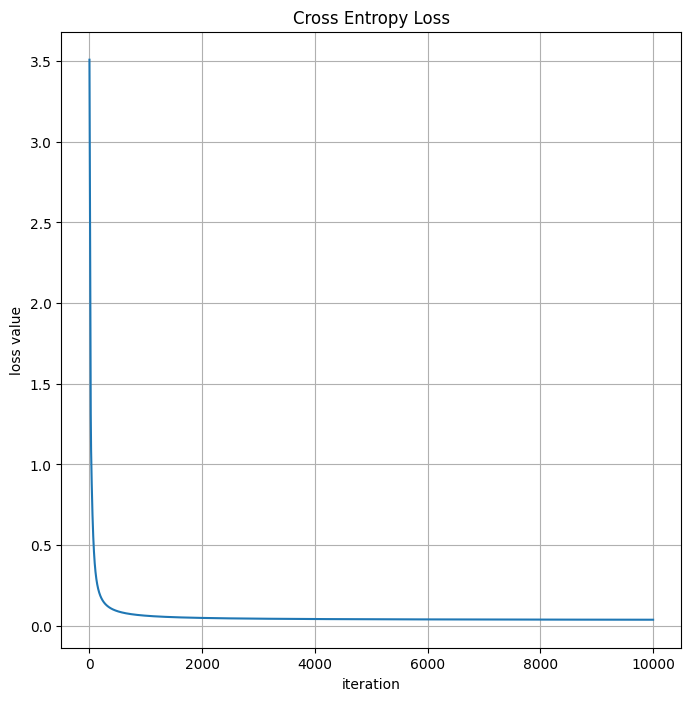

In [86]:
plt.figure(figsize=(8, 8))
plt.title('Cross Entropy Loss')
plt.xlabel('iteration')
plt.ylabel('loss value')
plt.plot(losses)
plt.grid(True)
plt.show()

Действительно значение кросс-энтропии в через 1000 итераций стало сильно ниже. То есть алгоритм обучился минимизировать кросс-энтропию.

Можем посмотреть, какое значение весов вернула модель

In [87]:
weights

array([ 0.91771545, -2.53198716,  1.21306642])

Что соответствует виду модели
$$\sigma(x,w) = \dfrac{1}{1 + e^{-w_0 + w_1x_1 + w_2x_2}}$$

Определим функцию для предиктов

In [88]:
def predict(X):
    X = add_const(X)
    return sigmoid(X @ weights)

Сделаем предикт на обучающей выборке и посмотрим, какой результат возвращает модель

In [89]:
y_hat = predict(X_train)

pd.DataFrame([y_train, y_hat]).T.rename(columns={2 : 'y train', 3 : 'predicted y train'}).head(10)

,0,1
0,1.0,0.996443
1,0.0,0.000317
2,1.0,0.991176
3,1.0,0.974642
4,0.0,0.007065
5,1.0,0.998605
6,0.0,0.012386
7,1.0,0.931124
8,0.0,0.003486
9,1.0,0.999093


Действительно модель возвращает нам вероятности принадлежности объекта в классу $y=1$.

Теперь построим визуализацию для данной модели. Для этого определим функцию, которая будет определять разделяющую плоскость. Граница неразрешенности задается уравнением
$$w_0 + w_1 x_1 + w_2 x_2 = 0,$$
то есть это граница, где модель будет возвращать значение $$\sigma (w_0 + w_1 x_1 + w_2 x_2) = \sigma(0) = \dfrac 12,$$
а значит модель не уверена в том, к какому классу отнести объект.

А тогда для визуализации выразим
$$x_2 = -\dfrac{w_1 x_1 + w_0}{w_2}.$$

In [90]:
def decision_boundary(x):
    return -(weights[1] * x + weights[0]) / weights[2]

Теперь выведем границу принятия решений, и все точки обучающего набора

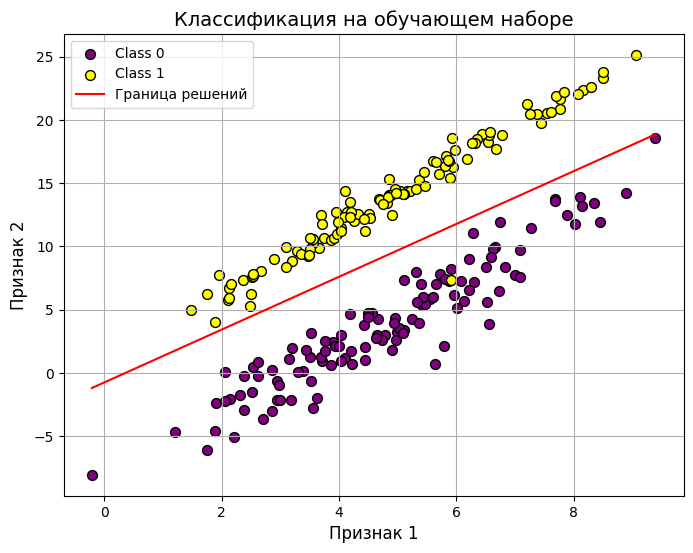

In [91]:
plt.figure(figsize=(8, 6))
scatter = plt.scatter(
    X_train[y_train == 0][:, 0], X_train[y_train == 0][:, 1], c='purple', edgecolor='k', s=50, label='Class 0', 
)

scatter = plt.scatter(
    X_train[y_train == 1][:, 0], X_train[y_train == 1][:, 1], c='yellow', edgecolor='k', s=50, label='Class 1',    
)

x_values = np.linspace(X_train[:, 0].min(), X_train[:, 0].max(), 100)
plt.plot(x_values, decision_boundary(x_values), color='red', linestyle='-', label='Граница решений')

plt.title("Классификация на обучающем наборе", fontsize=14)
plt.xlabel("Признак 1", fontsize=12)
plt.ylabel("Признак 2", fontsize=12)
plt.legend()
plt.grid(True)
plt.show()

Таким образом видно, что один объект действительно попал на границу неразрешенности, то есть для него модель не знает, какую метку класса указать.

Теперь перестроим функцию fit, чтобы она в процессе обучения записывала значения кросс-энтропии также и на тестовом наборе данных
(Можно не вдаваться в то, как это реализовано)

In [92]:
def fit(X_train, X_test, y_train, y_test, iterations=10000, lr=0.01):
    X_train = add_const(X_train)
    X_test = add_const(X_test)
    n, m = X_train.shape
    weights = np.random.uniform(size=m)
    train_losses = []
    test_losses = []
    
    for i in range(iterations):
    
        y_hat = sigmoid(X_train @ weights)
        y_pred = sigmoid(X_test @ weights)
        grad = - (X_train.T @ (y_train - y_hat)) / n
        weights -= lr * grad
        
        train_loss = cross_entropy_loss(y_hat, y_train)
        train_losses.append(train_loss)

        test_loss = cross_entropy_loss(y_pred, y_test)
        test_losses.append(test_loss)
    
    return train_losses, test_losses, weights

In [93]:
train_losses, test_losses, weights = fit(X_train, X_test, y_train, y_test)

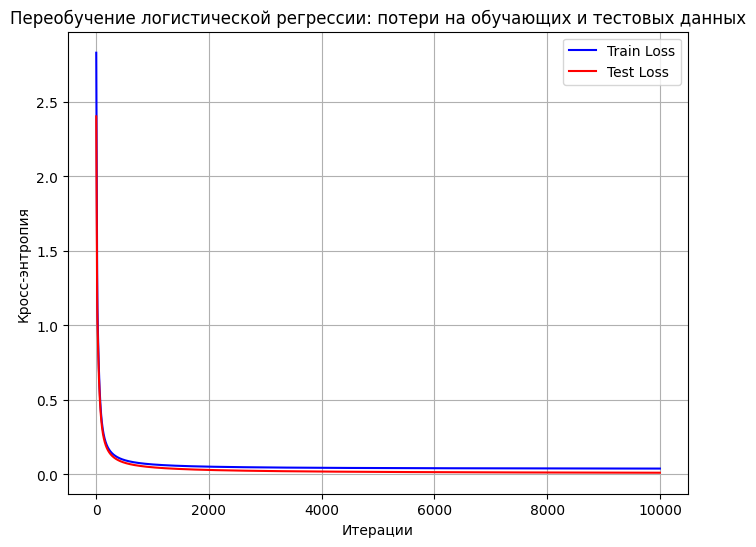

In [94]:
plt.figure(figsize=(8,6))

plt.plot(train_losses, label='Train Loss', color='blue')
plt.plot(test_losses, label='Test Loss', color='red')
plt.xlabel('Итерации')
plt.ylabel('Кросс-энтропия')
plt.title('Переобучение логистической регрессии: потери на обучающих и тестовых данных')
plt.legend()
plt.grid(True)
plt.show()

Как можно видеть, кросс-энтропия также минимизируется на тестовом наборе. То есть модель не переобучается.

Теперь визуализируем весь набор данных вместе с решающей границей

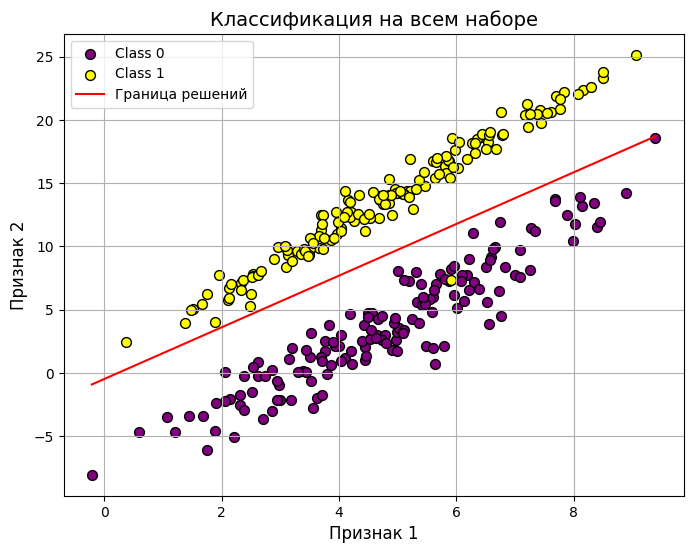

In [96]:
plt.figure(figsize=(8, 6))
scatter = plt.scatter(
    X[y == 0][:, 0], X[y == 0][:, 1], c='purple', edgecolor='k', s=50, label='Class 0', 
)

scatter = plt.scatter(
    X[y == 1][:, 0], X[y == 1][:, 1], c='yellow', edgecolor='k', s=50, label='Class 1',    
)

x_values = np.linspace(X[:, 0].min(), X[:, 0].max(), 1000)
plt.plot(x_values, decision_boundary(x_values), color='red', linestyle='-', label='Граница решений')

plt.title("Классификация на всем наборе", fontsize=14)
plt.xlabel("Признак 1", fontsize=12)
plt.ylabel("Признак 2", fontsize=12)
plt.legend()
plt.grid(True)
plt.show()

Как видно, на всем наборе данных модель достаточно хорошо справляется с классификацией.

Завернем модель в отдельный класс

In [159]:
class LogisticRegression():
    def __init__(self, iterations = 10000, lr = 0.01):
        self.iterations = iterations
        self.lr = lr
        self.weights = None

    def sigmoid(x):
        return 1 / (1 + np.exp(-x))

    def cross_entropy_loss(y_pred, y_true):
        return -np.mean(y_true * np.log(y_pred) + (1 - y_true) * np.log(1 - y_pred))

    def add_const(X):
        return np.hstack([np.ones((X.shape[0], 1)), X])
    
    def fit(self, X, y):
        X = add_const(X) # добавляем фиктивный столбец
        n, m = X.shape
        self.weights = np.random.uniform(size=m) # инициализируем веса w из равномерного распределения [0,1]
        losses = [] # список для значений кросс-энтропии
        
        for i in range(self.iterations):
        
            z = X @ self.weights
            y_pred = sigmoid(z)
            
            grad = - (X.T @ (y - y_pred)) / n
            
            self.weights -= self.lr * grad
            
            loss = cross_entropy_loss(y_pred, y)
            losses.append(loss) # записываем кросс-энтропию в список
        
        return losses
	
    def predict(self, X):
        X = add_const(X)
        return sigmoid(X @ self.weights)

## Оценка качества классификации

На тестовом наборе вычислим значения метрик классификации. Сперва сделаем предикт на тестовом наборе

In [128]:
y_pred_proba = predict(X_test)
y_pred_proba

array([9.93624767e-01, 1.37528479e-03, 1.80374068e-03, 4.31716057e-03,
       2.94988785e-03, 9.84016459e-01, 9.90840770e-01, 9.66336880e-01,
       4.81662708e-04, 8.74873555e-01, 7.37351392e-03, 9.99021741e-01,
       9.98233995e-01, 5.54938287e-03, 9.97534411e-01, 1.27339224e-04,
       1.29191740e-03, 2.30414320e-04, 1.93774269e-05, 9.98772042e-01,
       9.99873152e-01, 5.52581768e-05, 9.79500692e-01, 1.94312697e-04,
       9.98552967e-01, 9.99467785e-01, 5.36894881e-04, 9.99298390e-01,
       1.15359601e-01, 4.09681068e-03, 9.34767153e-01, 9.62673933e-01,
       9.68860921e-01, 1.63427287e-03, 9.95439839e-01, 2.83745505e-02,
       9.95555158e-01, 9.99746515e-01, 9.94313198e-01, 6.70683940e-04,
       9.95384707e-01, 9.57099801e-01, 1.96894137e-05, 9.84682554e-01,
       9.93064006e-01, 2.48594229e-05, 1.36074515e-03, 6.68628583e-04,
       9.97804307e-01, 1.79862945e-02, 9.71310816e-01, 9.91377996e-01,
       1.79231066e-02, 1.13111325e-04, 9.97378859e-01, 1.52967155e-05,
      

Чтобы получить из вероятностей значения меток -- просто округлим все вероятности

In [129]:
y_pred = np.round(y_pred_proba, 0)
y_pred

array([1., 0., 0., 0., 0., 1., 1., 1., 0., 1., 0., 1., 1., 0., 1., 0., 0.,
       0., 0., 1., 1., 0., 1., 0., 1., 1., 0., 1., 0., 0., 1., 1., 1., 0.,
       1., 0., 1., 1., 1., 0., 1., 1., 0., 1., 1., 0., 0., 0., 1., 0., 1.,
       1., 0., 0., 1., 0., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0.,
       0., 0., 0., 1., 1., 1., 0.])

Вычислим значения всех элементов матрицы ошибок. Матрица ошибок (confusion matrix) — таблица, отражающая распределение предсказаний:
$$\begin{bmatrix}TP & FN \\ FP & TN\end{bmatrix}$$

In [130]:
TP = np.sum((y_pred == 1.0) & (y_test == 1.0))
TN = np.sum((y_pred == 0.0) & (y_test == 0.0))
FP = np.sum((y_pred == 1.0) & (y_test == 0.0))
FN = np.sum((y_pred == 0.0) & (y_test == 1.0))

print(f'True Positive = {TP}')
print(f'False Negative = {FN}')
print(f'False Positive = {FP}')
print(f'True Negative = {TN}')

True Positive = 42
False Negative = 0
False Positive = 0
True Negative = 33


То есть модель не допустила ни одной ошибки на тестовом наборе. В таком случае вычислим значения метрик accuracy, preicision и recall

Accuracy (точность) — доля правильно классифицированных объектов:
$$\operatorname{Accuracy} = \dfrac{TP + TN}{TP + TN+FP + FN} = \dfrac 1 N \sum_{k=1}^N [y_k = \hat y_k]$$

In [131]:
accuracy = (TP + TN) / (TP + TN + FP + FN)
accuracy

1.0

Precision (точность положительных предсказаний) — доля правильно классифицированных положительных объектов среди всех предсказанных положительными:
$$\operatorname{Precision} = \dfrac{TP}{TP + FP}.$$
Recall (полнота) — доля правильно классифицированных положительных объектов среди всех истинных положительных:
$$\operatorname{Recall} = \dfrac{TP}{TP + FN}.$$

In [132]:
precision = TP / (TP + FP)
precision

1.0

In [133]:
recall = TP / (TP + FN)
recall

1.0

Очевидно, что все метрики равны 1.0, поскольку модель не допустила ни одной ошибки. Построим ROC кривую


ROC-кривая (Receiver Operating Characteristic) строится как зависимость True Positive Rate (TPR) от False Positive Rate (FPR) при варьировании порога $t$:
$$\operatorname{TPR} = \dfrac{TP}{TP + FN},\ \operatorname{FPR} = \dfrac{FP}{FP + TN}.$$
ROC-AUC (Area Under the Curve) — площадь под ROC-кривой. Это обобщенная метрика качества, оценивающая способность модели разделять классы.

In [134]:
from sklearn.metrics import auc

thresholds = np.sort(y_pred_proba)[::-1]
tpr_list = []
fpr_list = []

for t in thresholds:
    y_pred_threshold = (y_pred_proba >= t).astype(int)
    TP_t = np.sum((y_pred_threshold == 1) & (y_test == 1))
    TN_t = np.sum((y_pred_threshold == 0) & (y_test == 0))
    FP_t = np.sum((y_pred_threshold == 1) & (y_test == 0))
    FN_t = np.sum((y_pred_threshold == 0) & (y_test == 1))
    
    TPR = TP_t / (TP_t + FN_t) if (TP_t + FN_t) > 0 else 0
    FPR = FP_t / (FP_t + TN_t) if (FP_t + TN_t) > 0 else 0
    
    tpr_list.append(TPR)
    fpr_list.append(FPR)

roc_auc = auc(fpr_list, tpr_list)

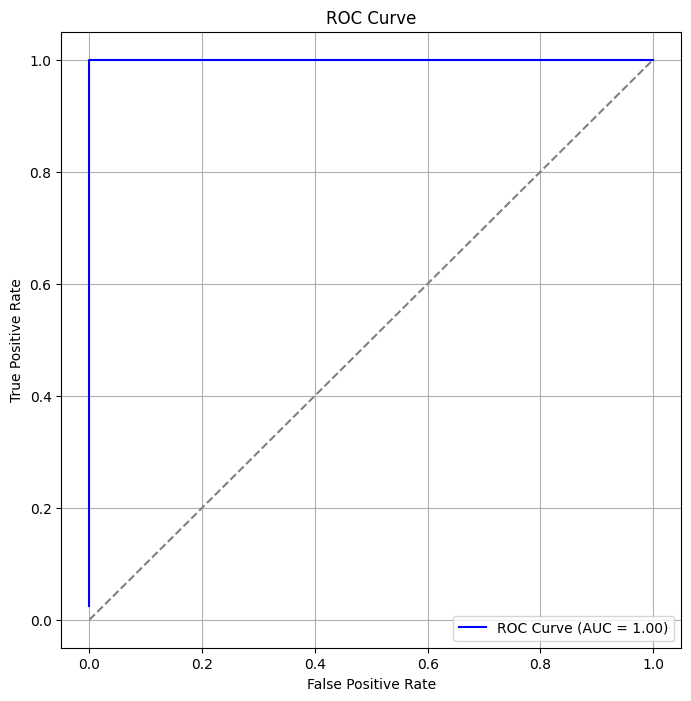

In [135]:
plt.figure(figsize=(8, 8))
plt.plot(fpr_list, tpr_list, color='blue', label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.grid(True)
plt.show()

Здесь тоже всё логично: классификатор работает наилучшим образом на тестовом наборе, поэтому ROC AUC = 1

## Решение задачи в $R^3$

Загружаем датасет

In [137]:
data = pd.read_csv('log-reg-data-2.csv')
display(data)

,feature_1,feature_2,feature_3,target
0,2.795906,-2.091982,7.453488,0
1,3.020061,-1.389400,7.916241,0
2,8.049193,2.311627,2.572349,0
3,10.985249,0.844814,0.264528,1
4,6.114533,1.113128,5.040241,0
...,...,...,...,...
495,5.328929,3.067854,8.609153,0
496,8.595882,0.260997,3.614835,1
497,10.604271,0.914878,1.990306,1
498,4.965678,3.613703,9.740147,0


В данном наборе данных уже 3 признака. Следовательно, моделирование мы будем производить в $R^3$. Сперва обозначим признаки за $X$ и метки класса за $y$

In [139]:
X = data.iloc[:, :-1].values
y = data['target'].values

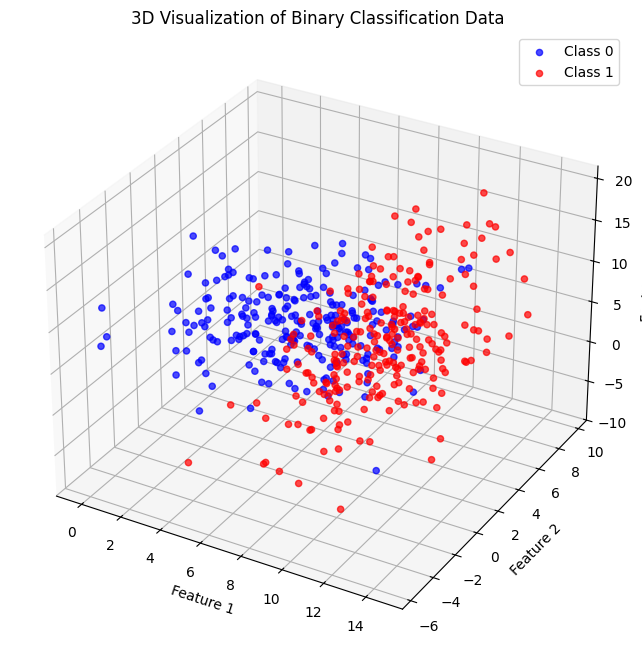

In [141]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

class_0 = X[y == 0]
class_1 = X[y == 1]

ax.scatter(class_0[:, 0], class_0[:, 1], class_0[:, 2], c='blue', label='Class 0', alpha=0.7)
ax.scatter(class_1[:, 0], class_1[:, 1], class_1[:, 2], c='red', label='Class 1', alpha=0.7)

ax.set_title('3D Visualization of Binary Classification Data')
ax.set_xlabel('Feature 1')
ax.set_ylabel('Feature 2')
ax.set_zlabel('Feature 3')
ax.legend()

plt.show()

Под таким ракурсом классы сильно перемешаны. Однако лучше взглянуть на интерактивный график

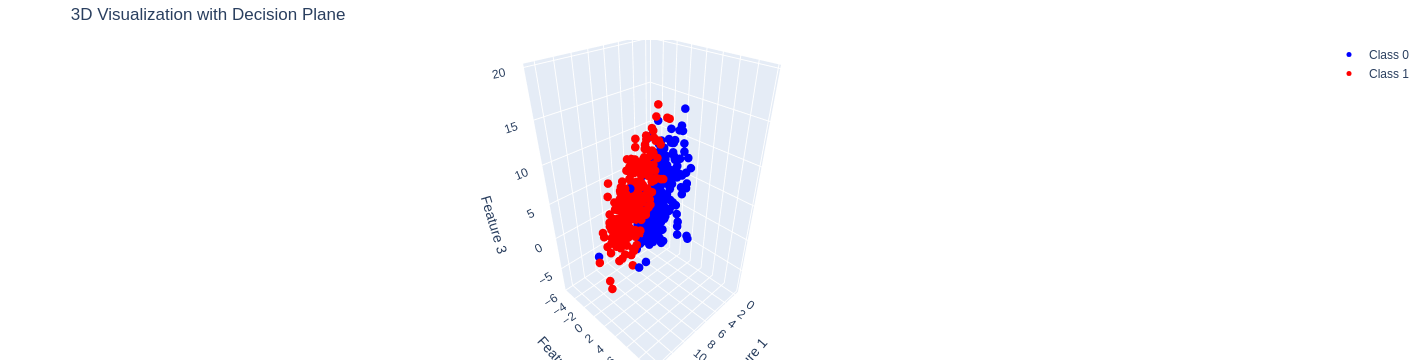

In [189]:
import plotly.graph_objects as go

# Сетка для плоскости
x1_range = np.linspace(X[:, 0].min(), X[:, 0].max(), 10)
x2_range = np.linspace(X[:, 1].min(), X[:, 1].max(), 10)
x1_grid, x2_grid = np.meshgrid(x1_range, x2_range)
x3_grid = decision_boundary(x1_grid, x2_grid)

# Создание 3D-графика с plotly
fig = go.Figure()

# Точки класса 0
fig.add_trace(go.Scatter3d(
    x=X[y == 0, 0],
    y=X[y == 0, 1],
    z=X[y == 0, 2],
    mode='markers',
    marker=dict(size=5, color='blue'),
    name='Class 0'
))

# Точки класса 1
fig.add_trace(go.Scatter3d(
    x=X[y == 1, 0],
    y=X[y == 1, 1],
    z=X[y == 1, 2],
    mode='markers',
    marker=dict(size=5, color='red'),
    name='Class 1'
))

# Настройки графика
fig.update_layout(
    title='3D Visualization with Decision Plane',
    scene=dict(
        xaxis_title='Feature 1',
        yaxis_title='Feature 2',
        zaxis_title='Feature 3'
    ),
    margin=dict(l=0, r=0, b=0, t=40)
)

# Отобразить график
fig.show()

Под определенным ракурсом можно увидеть, что классы линейно разделимы.

По классике разбиваем выборку на обучающий и тестовый наборы

In [145]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

Обучаем модель логистической регрессии

In [160]:
model = LogisticRegression()
losses = model.fit(X_train, y_train)

Выведем лосс

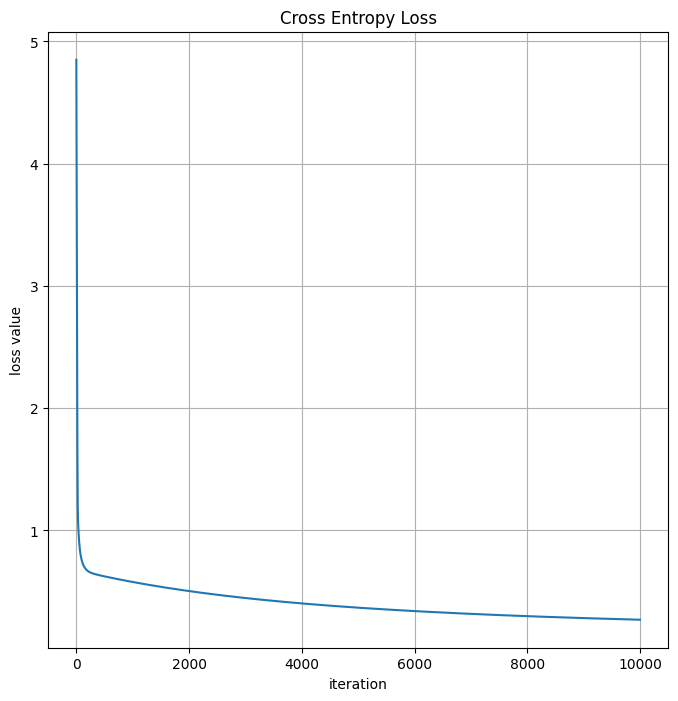

In [161]:
plt.figure(figsize=(8, 8))
plt.title('Cross Entropy Loss')
plt.xlabel('iteration')
plt.ylabel('loss value')
plt.plot(losses)
plt.grid(True)
plt.show()

Кросс-энтропия действительно снижается, это хорошо. Рассмотрим значения весов

In [163]:
weights = model.weights
weights

array([-5.4402183 ,  0.71276361, -0.51392507,  0.15068433])

То есть в этот раз граница решений задается в виде плоскости
$$w_0 + w_1 x_1 + w_2x_2 + w_3x_3 = 0.$$
Отсюда
$$x_3 = -\dfrac{w_1}{w_3}x_1 - \dfrac{w_2}{w_3}x_2 - \dfrac{w_0}{w_3}.$$

In [168]:
def decision_boundary(x1, x2):
    return -(weights[1] * x1 + weights[2] * x2 + weights[0]) / weights[3]

Тогда визуализация имеет вид

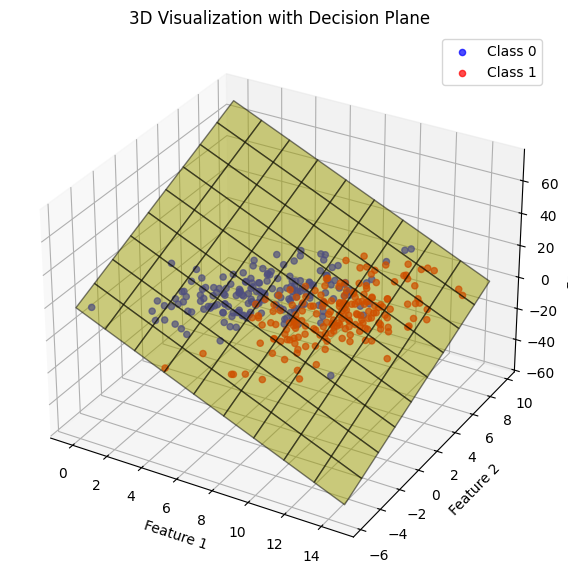

In [169]:
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

class_0 = X_train[y_train == 0]
class_1 = X_train[y_train == 1]

ax.scatter(class_0[:, 0], class_0[:, 1], class_0[:, 2], c='blue', label='Class 0', alpha=0.7)
ax.scatter(class_1[:, 0], class_1[:, 1], class_1[:, 2], c='red', label='Class 1', alpha=0.7)

x1_range = np.linspace(X[:, 0].min(), X[:, 0].max(), 10)
x2_range = np.linspace(X[:, 1].min(), X[:, 1].max(), 10)
x1_grid, x2_grid = np.meshgrid(x1_range, x2_range)
x3_grid = decision_boundary(x1_grid, x2_grid)

ax.plot_surface(x1_grid, x2_grid, x3_grid, color='yellow', alpha=0.5, edgecolor='k')

# Настройки графика
ax.set_title('3D Visualization with Decision Plane')
ax.set_xlabel('Feature 1')
ax.set_ylabel('Feature 2')
ax.set_zlabel('Feature 3')
ax.legend()

plt.show()

Статичный график не очень наглядно описывает разделение. Воспользуемся интерактивным графиком

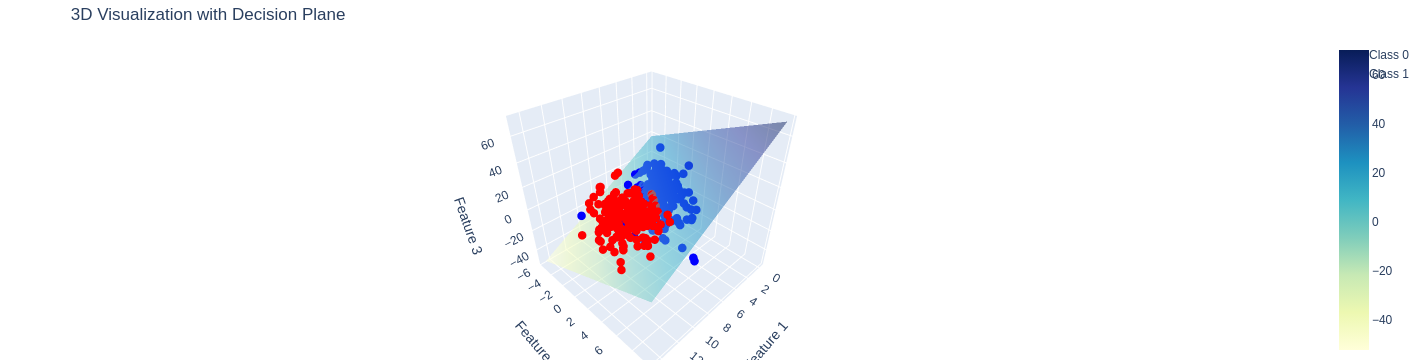

In [190]:
# Сетка для плоскости
x1_range = np.linspace(X_train[:, 0].min(), X_train[:, 0].max(), 10)
x2_range = np.linspace(X_train[:, 1].min(), X_train[:, 1].max(), 10)
x1_grid, x2_grid = np.meshgrid(x1_range, x2_range)
x3_grid = decision_boundary(x1_grid, x2_grid)

# Создание 3D-графика с plotly
fig = go.Figure()

# Точки класса 0
fig.add_trace(go.Scatter3d(
    x=X_train[y_train == 0, 0],
    y=X_train[y_train == 0, 1],
    z=X_train[y_train == 0, 2],
    mode='markers',
    marker=dict(size=5, color='blue'),
    name='Class 0'
))

# Точки класса 1
fig.add_trace(go.Scatter3d(
    x=X_train[y_train == 1, 0],
    y=X_train[y_train == 1, 1],
    z=X_train[y_train == 1, 2],
    mode='markers',
    marker=dict(size=5, color='red'),
    name='Class 1'
))

# Разделяющая плоскость
fig.add_trace(go.Surface(
    x=x1_grid, 
    y=x2_grid, 
    z=x3_grid, 
    colorscale='YlGnBu', 
    opacity=0.5,
    name='Decision Plane'
))

# Настройки графика
fig.update_layout(
    title='3D Visualization with Decision Plane',
    scene=dict(
        xaxis_title='Feature 1',
        yaxis_title='Feature 2',
        zaxis_title='Feature 3'
    ),
    margin=dict(l=0, r=0, b=0, t=40)
)

# Отобразить график
fig.show()

Вращая, можно увидеть, что наша модель достаточно хорошо построила разделяющую плоскость. Оценим с помощью метрик качество модели

In [171]:
y_pred_proba = model.predict(X_test)
y_pred_proba

array([0.09485739, 0.33184597, 0.31909372, 0.05788499, 0.27141058,
       0.23592479, 0.29671987, 0.88713243, 0.88754495, 0.69718922,
       0.13882084, 0.90532447, 0.92047912, 0.78244025, 0.93013941,
       0.10606005, 0.12771284, 0.27365561, 0.24085793, 0.14276222,
       0.87559851, 0.5042126 , 0.71558529, 0.58804107, 0.81527395,
       0.95686712, 0.87521197, 0.18985751, 0.57218973, 0.13288234,
       0.40382678, 0.35374216, 0.86715283, 0.16176118, 0.37673324,
       0.88116556, 0.34881758, 0.12602216, 0.31448333, 0.39269404,
       0.25562028, 0.78569246, 0.89794452, 0.45464688, 0.84473708,
       0.64729938, 0.22284691, 0.78532774, 0.78417375, 0.73207363,
       0.35813541, 0.25853524, 0.84374151, 0.88853102, 0.80758044,
       0.95967517, 0.24533048, 0.18083562, 0.40678471, 0.83121283,
       0.32015983, 0.73085519, 0.08136068, 0.05406274, 0.44618609,
       0.79821513, 0.09597211, 0.26077115, 0.96255044, 0.08944489,
       0.85118117, 0.57020354, 0.70231603, 0.91432593, 0.16114

Чтобы получить из вероятностей значения меток -- просто округлим все вероятности

In [172]:
y_pred = np.round(y_pred_proba, 0)
y_pred

array([0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 0., 1., 1., 1., 1., 0., 0.,
       0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 0., 1., 0., 0., 0., 1., 0.,
       0., 1., 0., 0., 0., 0., 0., 1., 1., 0., 1., 1., 0., 1., 1., 1., 0.,
       0., 1., 1., 1., 1., 0., 0., 0., 1., 0., 1., 0., 0., 0., 1., 0., 0.,
       1., 0., 1., 1., 1., 1., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0.,
       0., 1., 1., 1., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 0., 1., 0.,
       0., 0., 1., 1., 0., 1., 1., 1., 1., 0., 0., 0., 1., 0., 1., 0., 0.,
       0., 1., 1., 0., 1., 1.])

Вычислим значения всех элементов матрицы ошибок. Матрица ошибок (confusion matrix) — таблица, отражающая распределение предсказаний:
$$\begin{bmatrix}TP & FN \\ FP & TN\end{bmatrix}$$

In [173]:
TP = np.sum((y_pred == 1.0) & (y_test == 1.0))
TN = np.sum((y_pred == 0.0) & (y_test == 0.0))
FP = np.sum((y_pred == 1.0) & (y_test == 0.0))
FN = np.sum((y_pred == 0.0) & (y_test == 1.0))

print(f'True Positive = {TP}')
print(f'False Negative = {FN}')
print(f'False Positive = {FP}')
print(f'True Negative = {TN}')

True Positive = 54
False Negative = 5
False Positive = 4
True Negative = 62


Заметно, что модель допускает ошибки. Но их достаточно мало.

Accuracy (точность) — доля правильно классифицированных объектов:
$$\operatorname{Accuracy} = \dfrac{TP + TN}{TP + TN+FP + FN}$$

In [182]:
accuracy = (TP + TN) / (TP + TN + FP + FN)
accuracy

0.928

Precision (точность положительных предсказаний) — доля правильно классифицированных положительных объектов среди всех предсказанных положительными:
$$\operatorname{Precision} = \dfrac{TP}{TP + FP}.$$
Recall (полнота) — доля правильно классифицированных положительных объектов среди всех истинных положительных:
$$\operatorname{Recall} = \dfrac{TP}{TP + FN}.$$

In [183]:
precision = TP / (TP + FP)
precision

0.9310344827586207

In [184]:
recall = TP / (TP + FN)
recall

0.9152542372881356

Очевидно, что все метрики равны 1.0, поскольку модель не допустила ни одной ошибки. Построим ROC кривую


ROC-кривая (Receiver Operating Characteristic) строится как зависимость True Positive Rate (TPR) от False Positive Rate (FPR) при варьировании порога $t$:
$$\operatorname{TPR} = \dfrac{TP}{TP + FN},\ \operatorname{FPR} = \dfrac{FP}{FP + TN}.$$
ROC-AUC (Area Under the Curve) — площадь под ROC-кривой. Это обобщенная метрика качества, оценивающая способность модели разделять классы.

In [185]:
from sklearn.metrics import auc

thresholds = np.sort(y_pred_proba)[::-1]
tpr_list = []
fpr_list = []

for t in thresholds:
    y_pred_threshold = (y_pred_proba >= t).astype(int)
    TP_t = np.sum((y_pred_threshold == 1) & (y_test == 1))
    TN_t = np.sum((y_pred_threshold == 0) & (y_test == 0))
    FP_t = np.sum((y_pred_threshold == 1) & (y_test == 0))
    FN_t = np.sum((y_pred_threshold == 0) & (y_test == 1))
    
    TPR = TP_t / (TP_t + FN_t) if (TP_t + FN_t) > 0 else 0
    FPR = FP_t / (FP_t + TN_t) if (FP_t + TN_t) > 0 else 0
    
    tpr_list.append(TPR)
    fpr_list.append(FPR)

roc_auc = auc(fpr_list, tpr_list)

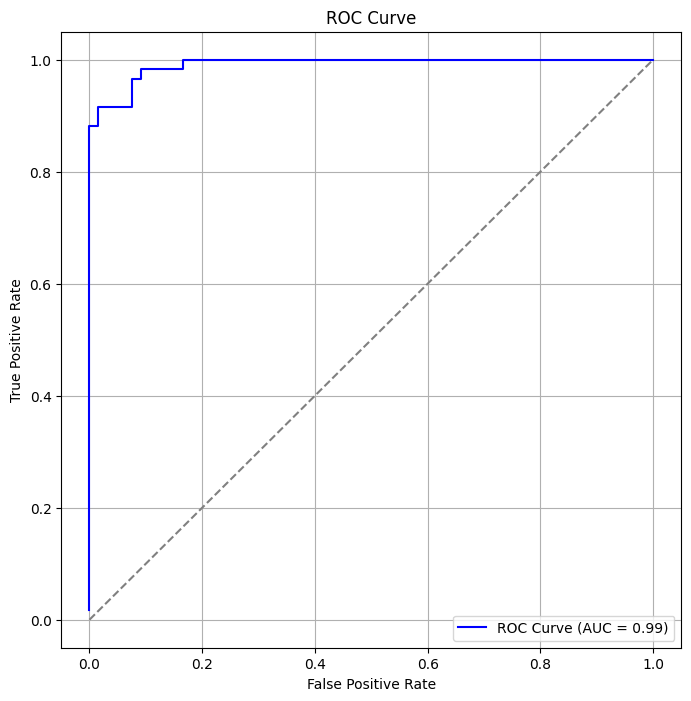

In [186]:
plt.figure(figsize=(8, 8))
plt.plot(fpr_list, tpr_list, color='blue', label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.grid(True)
plt.show()

Таким образом, значения всех метрик достаточно высокие, следовательно, мы можем считать модель качественной.